<div class="alert alert-block alert-info">

<h1 style="font-family:verdana;"> Description:</h1>

<ul>
<li><p style="font-family:verdana;">
In this notebook, we are going to develop a model to predict Chicago's Taxi Trip total cost which includes fare, tips, extras and toll.
</p></li>
    
<li><p style="font-family:verdana;">
To do so, we will perform data preparation, feature engineering, model selection, hyperparameter tuning.
</p></li>

</div>

## Index
1. [Import needed packages](#step-0-import-the-needed-packages)
2. [Load a sample data from BQ](#step-1-load-data-from-bq)
3. [Data preprocessing I](#step-2-data-preprocessing)
4. [Feature engineering](#step-3-feature-engineering)
5. [ML Model](#step-4-model-development)
    1. [Finding the best model with PyCaret](#41-finding-the-proper-model)
    2. [Data preparation](#42-data-preparation)
    3. [Gradient Boosting Regressor and Hyperparameter search](#43-gradient-boosting-regressor-and-hyperparameter-search)
6. [Conclusions](#5-conclusions)

## Step 0: import the needed packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from pycaret.regression import RegressionExperiment
from google.cloud import bigquery

import warnings

warnings.filterwarnings('ignore')

## Step 1: Load data from BQ

With the insights from the [EDA notebook](CTT_01_EDA.ipynb), we will query for certain features with corresponding threshold to avoid missing values.

For the purpose of this development stage, we will work with reduced random sample of the dataset.

In [2]:
# Define sample size (e.g., 100,000 rows)
sample_size = 2000000

# Define the public dataset and table
public_project = "bigquery-public-data"
public_dataset = "chicago_taxi_trips"
public_table = "taxi_trips"

# Construct a query to sample the data
query = f"""
SELECT 
    trip_seconds,
    trip_miles,
    trip_total,
    pickup_latitude,
    pickup_longitude,
    dropoff_latitude,
    dropoff_longitude,
    payment_type,
    trip_start_timestamp,
    pickup_community_area,
    dropoff_community_area
FROM 
    `{public_project}.{public_dataset}.{public_table}`
WHERE
    trip_seconds > 0 AND trip_seconds < 7200 AND
    trip_miles > 0 AND
    trip_total > 0 AND trip_total < 250 AND
    pickup_latitude IS NOT NULL AND
    pickup_longitude IS NOT NULL AND
    dropoff_latitude IS NOT NULL AND
    dropoff_longitude IS NOT NULL AND
    payment_type = "Cash" AND payment_type = "Cash" AND
    trip_start_timestamp IS NOT NULL AND
    pickup_community_area IS NOT NULL AND
    dropoff_community_area IS NOT NULL AND
    RAND() < {sample_size}/(SELECT COUNT(*) FROM `{public_project}.{public_dataset}.{public_table}`)
"""
#    RAND() < {sample_size}/(SELECT COUNT(*) FROM `{public_project}.{public_dataset}.{public_table}`)

# Create a BigQuery client
client = bigquery.Client()

# Query the data and return a pandas DataFrame
df_sample = client.query(query).to_dataframe()

## Step 2: Data preprocessing

First we will encode working days and hours into binary values. From Monday to Friday we will assign 1, Saturday/Sunday will be 0. Working hours are considered to be from 8am to 6pm, and then be encoded as 1, otherwise 0. 

Also, Cash payment type will be encoded to 1 and Credit Card to 0.

In [3]:
# Convert trip_start_timestamp to datetime
df_sample["trip_start_datetime"] = pd.to_datetime(df_sample["trip_start_timestamp"])

# Extract the day of the week from the trip start datetime
df_sample["day_of_week"] = df_sample["trip_start_datetime"].dt.weekday

# Extract hour of the day from the trip start datetime
df_sample["hour_of_day"] = df_sample["trip_start_datetime"].dt.hour

# Encode work day to 1 and weekend to 0
df_sample["work_day"] = df_sample["day_of_week"].apply(lambda x: 1 if x < 5 else 0)

# Encode work hours to 1 and non-work hours to 0
df_sample["work_hour"] = df_sample["hour_of_day"].apply(lambda x: 1 if 8 <= x <= 18 else 0)

# Encode Cash to 1 and Credit Card to 0
df_sample["payment_type_binary"] = df_sample["payment_type"].apply(lambda x: 1 if x == "Cash" else 0)

# Drop trip_start_timestamp, trip_start_datetime, day_of_week, hour_of_day and payment_type columns
df_sample.drop(columns=["trip_start_timestamp", "trip_start_datetime", "payment_type", "day_of_week", "hour_of_day"], inplace=True)

## Step 3: Feature engineering

Split the dataset into features and target

In [4]:
df_features = df_sample.drop(columns=["trip_total"])
df_target = df_sample["trip_total"]

Select a random sample of 10k rows

In [5]:
df_features_sample = df_features.sample(n=10000, random_state=42)
df_target_sample = df_target.sample(n=10000, random_state=42)

Let's see the features importance previous to a feature engineering task

In [6]:
selector = ExtraTreesRegressor()
selector.fit(df_features_sample, df_target_sample)

ExtraTreesRegressor()

In [7]:
for feat, importance in zip(df_features.columns, selector.feature_importances_):
    print(f'feature: {feat}, importance: {importance*100:.2f}')

feature: trip_seconds, importance: 40.59
feature: trip_miles, importance: 16.17
feature: pickup_latitude, importance: 1.71
feature: pickup_longitude, importance: 14.00
feature: dropoff_latitude, importance: 2.43
feature: dropoff_longitude, importance: 10.23
feature: pickup_community_area, importance: 8.56
feature: dropoff_community_area, importance: 5.32
feature: work_day, importance: 0.40
feature: work_hour, importance: 0.61
feature: payment_type_binary, importance: 0.00


Paymant type do not have any importance, so we can drop that feature. Also, it is not certain that we will be able to know the pickup and dropoff coordinates, so lets just keep the pickup and dropoff community areas.

Also, we can calculate the average trip speed as trip_miles/trip_seconds in miles per hour.

In [8]:
df_features = df_sample.drop(columns=["payment_type_binary", "trip_total", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
df_features["trip_speed"] = df_features["trip_miles"] / df_features["trip_seconds"] * 3600

## Step 4: Model development

#### 4.1 Finding the proper model

Using PyCaret, we will analize a bunch of different regression algorithms and find the best one for the problem.

Instance PyCaret and find the best model. To avoid high RAM usage, we will explore different regression models with just 10k rows.

In [9]:
data = df_sample.drop(columns=["payment_type_binary", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
data["trip_speed"] = data["trip_miles"] / data["trip_seconds"] * 3600
# Limit data to 10k rows
data = data.sample(10000, random_state=123)
s = RegressionExperiment()
s.setup(data, target = "trip_total", session_id = 123, n_jobs=9)

,Description,Value
0,Session id,123
1,Target,trip_total
2,Target type,Regression
3,Original data shape,"(10000, 8)"
4,Transformed data shape,"(10000, 8)"
5,Transformed train set shape,"(7000, 8)"
6,Transformed test set shape,"(3000, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [10]:
best = s.compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.2223,7.8197,2.7730,0.9204,0.1371,0.5313,51.2330
gbr,Gradient Boosting Regressor,1.2723,8.1287,2.8259,0.9176,0.1434,0.5538,0.0860
rf,Random Forest Regressor,1.2487,8.3328,2.8612,0.9153,0.1434,0.5489,0.1820
et,Extra Trees Regressor,1.2898,8.4551,2.8691,0.9143,0.1456,0.5607,0.1210
xgboost,Extreme Gradient Boosting,1.2947,9.1861,3.0026,0.9061,0.1474,0.5749,17.0560
dt,Decision Tree Regressor,1.5742,13.3203,3.6238,0.8645,0.1813,0.5568,0.0100
knn,K Neighbors Regressor,1.7481,13.9376,3.7239,0.8600,0.1690,0.5355,0.0120
lr,Linear Regression,2.1185,16.2894,4.0009,0.8350,0.2119,0.5405,0.2280
br,Bayesian Ridge,2.1174,16.2904,4.0010,0.8350,0.2115,0.5405,0.0070
ridge,Ridge Regression,2.1184,16.2894,4.0009,0.8350,0.2119,0.5405,0.0080


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [11]:
print(best)

LGBMRegressor(n_jobs=9, random_state=123)


In [12]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

With the model analysis we can conclude that GradientBoostingRegressor is the best model. So lets go further and train the top three models with the whole dataset sample.

#### 4.2 Data preparation

Let's begin scaling the dataset

In [13]:
scaler = StandardScaler()
df_features_scaled = scaler.fit_transform(df_features)

Split into train and test sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_features_scaled, df_target, test_size=0.2, random_state=123)

#### 4.3 Gradient Boosting Regressor and hyperparameter search

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

# Define the model
model = GradientBoostingRegressor(random_state=42)

# Define the grid of hyperparameters
param_distributions = {
    "n_estimators": [3, 10, 30, 100, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]
}

# Define the CV
search_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    scoring="neg_mean_absolute_error",
    n_iter=20,
    random_state=0,
    n_jobs=-1,
    cv=5
)

# Perform the hyperparameter search
sarch_result = search_cv.fit(X_train, y_train)


# Get the best hyperparameters
best_hyperparameters = sarch_result.best_params_
print(f"Best hyperparameters:\n{best_hyperparameters}")


Best hyperparameters:
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05}


In [16]:
# Train the model with the best hyperparameters
gbr = GradientBoostingRegressor(**best_hyperparameters, random_state=42)

# Fit the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=300,
                          random_state=42)

In [17]:
# Make predictions on the test set
y_pred_gbr = gbr.predict(X_test)

Model perfomance

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_metrics(model: str, y_test: list[float], y_pred: list[float]) -> None:
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)

    # Calculate the mean absolute error
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate the R2 score
    r2 = r2_score(y_test, y_pred)

    # Print the metrics
    print(f"Metrics for {model}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print("---"*10)

In [19]:
get_metrics("Gradient Boosting Regressor", y_test, y_pred_gbr)

Metrics for Gradient Boosting Regressor:
Mean Squared Error: 6.22
Mean Absolute Error: 1.10
R2 Score: 0.94
------------------------------


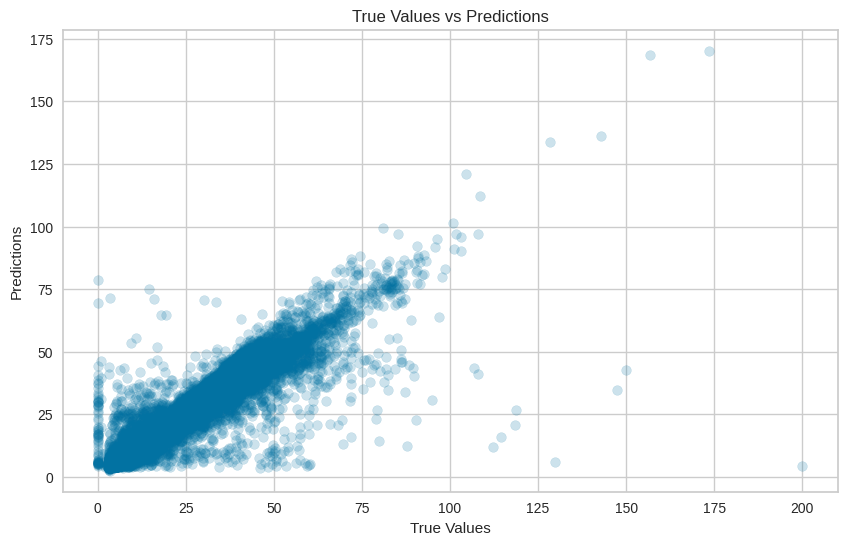

In [20]:
# plot y_test vs y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gbr, alpha=0.2)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True Values vs Predictions")
plt.show()

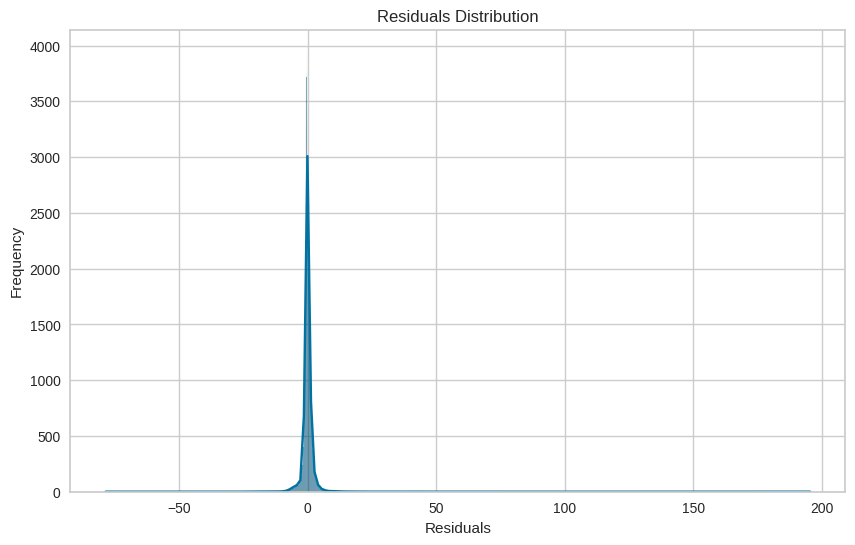

In [21]:
# plot residuals
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred_gbr
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residuals Distribution")
plt.show()


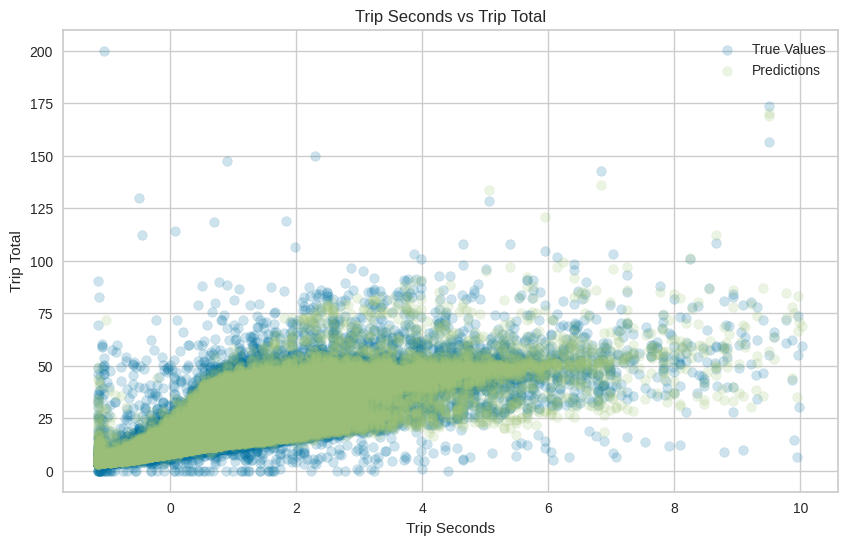

In [22]:
# plot trip seconds from X test vs y test and y pred
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, alpha=0.2, label="True Values")
plt.scatter(X_test[:, 0], y_pred_gbr, alpha=0.2, label="Predictions")
plt.xlabel("Trip Seconds")
plt.ylabel("Trip Total")
plt.title("Trip Seconds vs Trip Total")
plt.legend()
plt.show()

## 5. Conclusions

As we can see from section [4.1](#41-finding-the-proper-model), Gradient Boosting Regressor is the best performant model over a sample of 10k rows and extending that model to the whole sample of $\~900k$ it still performs great with a $R^2 = 0.94$. Also, the plots above support the model performance by shedding light over the model behaviour. 

With the model defined, we are ready to develop the MLOps pipeline. Given that the purpose of this demo is to build an end-to-end Tensorflow pipeline, we will develop a simple neural network and later we will analize that model and compare it with the Gradient Boosting Regressor which will be considered as a baseline model.